In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
keras.utils.set_random_seed(42)

In [3]:
img_paths = glob.glob("dataset/train/*.jpg")
len(img_paths)

10000

(26, 47, 3)


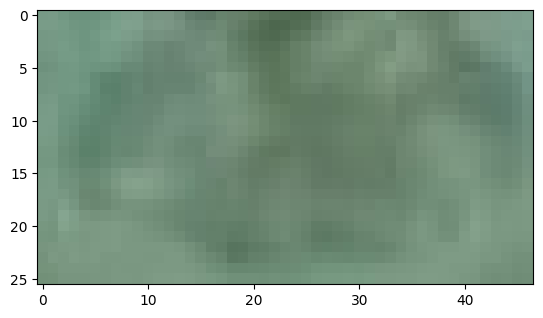

In [4]:
img = cv2.imread(img_paths[20])
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [5]:
X_train, X_test = train_test_split(img_paths, train_size=0.8, random_state=42)

В рамках экспериментов с трансформациями изображений проводились попытки изменить насыщенность и hue, но в итоге остановился только на обрезе краев изображений

In [6]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, 3)

    height, width = tf.shape(img)[0], tf.shape(img)[1]
    crop_percentage = 0.10
    crop_height = tf.cast(tf.cast(height, tf.float32) * crop_percentage, tf.int32)
    crop_width = tf.cast(tf.cast(width, tf.float32) * crop_percentage, tf.int32)
    img = tf.image.crop_to_bounding_box(img, crop_height, crop_width, height - 2 * crop_height, width - 2 * crop_width)

    # img = tf.image.random_hue(img, max_delta=0.2, seed=42)  # Adjust the max_delta as needed
    # img = tf.image.random_saturation(img, lower=0.5, upper=1.5, seed=42)
    
    img = tf.image.resize(img,[48, 48])
    img = tf.cast(img, tf.float32)
    img = img/255
    
    return img

In [7]:
batch_size = 256

data_train = tf.data.Dataset.from_tensor_slices(X_train)
data_train = data_train.map(load_img)
dataset_train = tf.data.Dataset.zip((data_train, data_train))
print(len(dataset_train))

dataset_train = dataset_train.shuffle(500).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

8000


2024-01-06 17:24:05.256292: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-06 17:24:05.256316: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-06 17:24:05.256340: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-06 17:24:05.256414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-06 17:24:05.256432: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
data_test = tf.data.Dataset.from_tensor_slices(X_test)
data_test = data_test.map(load_img)
dataset_test = tf.data.Dataset.zip((data_test, data_test))
print(len(dataset_test))

dataset_test = dataset_test.shuffle(500).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

2000


In [9]:
def load_data(paths):
    data = []
    for path in paths:
        data.append(load_img(path))
    return np.asarray(data)

In [10]:
df_test = pd.read_csv("dataset/test/test_annotation.txt", sep=' ', names = ['img_name', 'class'])
df_test['img_name'] = df_test['img_name'].apply(lambda x: "dataset/test/imgs/"+x)
test_data = load_data(df_test['img_name'].to_list())
df_test

,img_name,class
0,dataset/test/imgs/b9bc8d6d-0cb6-40c2-a38d-61b4...,0
1,dataset/test/imgs/9d3893a3-c877-4873-81c5-91aa...,0
2,dataset/test/imgs/4f5cef60-bf06-4daf-be8d-a36b...,0
3,dataset/test/imgs/37ee27b2-89a3-4b66-98a4-fb39...,0
4,dataset/test/imgs/43543d1a-24b6-4018-af56-27fe...,0
...,...,...
3789,dataset/test/imgs/00bd95dc-4f01-404b-9f59-1f13...,0
3790,dataset/test/imgs/09e62c5f-f3bf-4de2-bc76-2e3e...,0
3791,dataset/test/imgs/e92ab320-3577-424f-8c32-f5df...,0
3792,dataset/test/imgs/db135776-bf7f-4450-83b9-5cc5...,0


In [11]:
proliv_paths = glob.glob("dataset/proliv/*.jpg")
len(proliv_paths)

154

In [12]:
data_proliv = load_data(proliv_paths)

In [13]:
inputs = keras.Input(shape = (48, 48, 3))
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', strides=2)(x)
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', strides=2)(x)
x = keras.layers.Conv2D(128, (3, 3), padding='same')(x)
x = keras.layers.Conv2D(128, (3, 3), padding='same', strides=2)(x)
x = keras.layers.Conv2D(128, (3, 3), padding='same')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.Conv2D(64, (3, 3), padding='same')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.Conv2D(32, (3, 3), padding='same')(x)
x = keras.layers.UpSampling2D(2)(x)
outputs = keras.layers.Conv2D(3, (3, 3), padding='same', activation = 'sigmoid')(x)
model_1 = keras.Model(inputs, outputs)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 128)         147584

In [14]:
model_1.compile(optimizer="Adam", loss="mse")

In [57]:
hist = model_1.fit(dataset_train, 
                   epochs=10, 
                   validation_data=dataset_test, 
                   callbacks=tf.keras.callbacks.TensorBoard(log_dir='logs/exp1'))

Epoch 1/10
32/32 [==============================] - 4s 125ms/step - loss: 4.7243e-04 - val_loss: 3.6488e-04
Epoch 2/10
32/32 [==============================] - 4s 124ms/step - loss: 3.5841e-04 - val_loss: 3.4631e-04
Epoch 3/10
32/32 [==============================] - 4s 124ms/step - loss: 3.4150e-04 - val_loss: 3.1642e-04
Epoch 4/10
32/32 [==============================] - 4s 123ms/step - loss: 3.0834e-04 - val_loss: 2.5904e-04
Epoch 5/10
32/32 [==============================] - 4s 124ms/step - loss: 3.9280e-04 - val_loss: 3.4661e-04
Epoch 6/10
32/32 [==============================] - 4s 125ms/step - loss: 3.1423e-04 - val_loss: 2.5619e-04
Epoch 7/10
32/32 [==============================] - 4s 124ms/step - loss: 2.4773e-04 - val_loss: 2.3025e-04
Epoch 8/10
32/32 [==============================] - 4s 125ms/step - loss: 2.2905e-04 - val_loss: 2.0419e-04
Epoch 9/10
32/32 [==============================] - 4s 125ms/step - loss: 2.2187e-04 - val_loss: 2.3911e-04
Epoch 10/10
32/32 [=========

In [58]:
model_1.evaluate(dataset_test)

8/8 [==============================] - 0s 37ms/step - loss: 2.3448e-04


0.00023447777493856847

<Axes: >

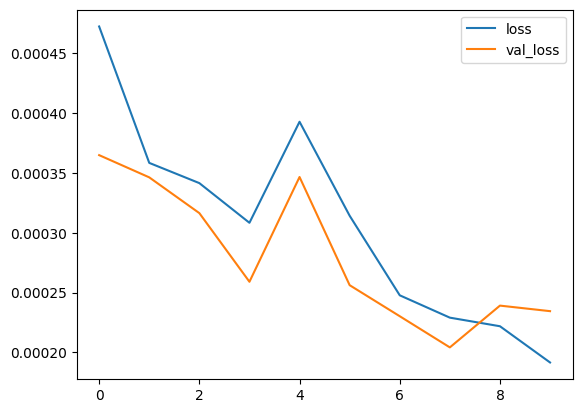

In [59]:
#График изменения функции потерь
history_df = pd.DataFrame(hist.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

1/1 [==============================] - 0s 16ms/step


[[], []]

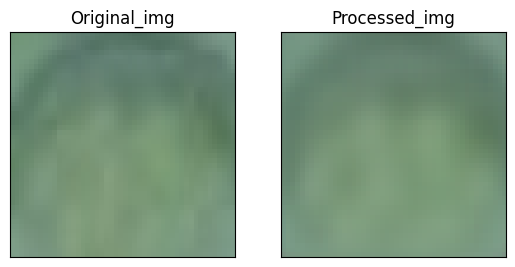

In [60]:
img = np.expand_dims(load_img(X_train[10]), axis=0)
res_img = model_1.predict(img)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img[0])
axs[0].set_title('Original_img')
axs[0].set(xticks=[], yticks=[])
axs[1].imshow(res_img[0])
axs[1].set_title('Processed_img')
axs[1].set(xticks=[], yticks=[])

In [61]:
proliv_paths = glob.glob("dataset/proliv/*.jpg")
len(proliv_paths)

154

1/1 [==============================] - 0s 16ms/step
MSE = 0.0014231220120564103


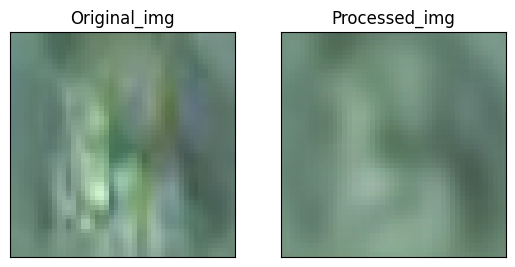

In [62]:
proliv_img = np.expand_dims(load_img(proliv_paths[130]), axis=0)
res_proliv = model_1.predict(proliv_img)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(proliv_img[0])
axs[0].set_title('Original_img')
axs[0].set(xticks=[], yticks=[])
axs[1].imshow(res_proliv[0])
axs[1].set_title('Processed_img')
axs[1].set(xticks=[], yticks=[])
print(f"MSE = {np.mean(np.square(proliv_img-res_proliv))}")

## 2 способа поиска оптимального порога

- через дерево решений
- через ROC-кривую


In [63]:
data_proliv = load_data(proliv_paths)
proliv_res = model_1.predict(data_proliv)

5/5 [==============================] - 0s 10ms/step


In [64]:
mse_list = []
for i in range(len(proliv_res)):
    mse_list.append(np.mean(np.square(data_proliv[i]-proliv_res[i])))
mse = np.mean(mse_list)
print(mse)

0.001470353


In [66]:
orig_imgs = load_data(img_paths[:1000])
mse_list_orig = []
for i in range(len(orig_imgs)):
    mse_list_orig.append(np.mean(np.square(orig_imgs[i]-model_1.predict(np.expand_dims(orig_imgs[i], 
                                                                                  axis=0), 
                                                                   verbose=0))))
mse = np.mean(mse_list_orig)
print(mse)

0.0002330113


In [67]:
orig_data = pd.DataFrame({'mse':mse_list_orig, 'class': [0 for _ in range(len(mse_list_orig))]}, 
             columns=['mse', 'class'])
proliv_data = pd.DataFrame({'mse':mse_list, 'class': [1 for _ in range(len(mse_list))]}, 
             columns=['mse', 'class'])
mse_data = pd.concat([orig_data, proliv_data], axis = 0, ignore_index=True)

In [68]:
mse_data

,mse,class
0,0.000240,0
1,0.000197,0
2,0.000199,0
3,0.000247,0
4,0.000220,0
...,...,...
1149,0.001184,1
1150,0.001741,1
1151,0.000945,1
1152,0.002362,1


In [69]:
mse_data['mse'] *= 100

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
model_tree = DecisionTreeClassifier(max_depth=1, criterion='gini').fit(mse_data.drop(columns='class'), mse_data['class'])

Поиск порога через дерево решений

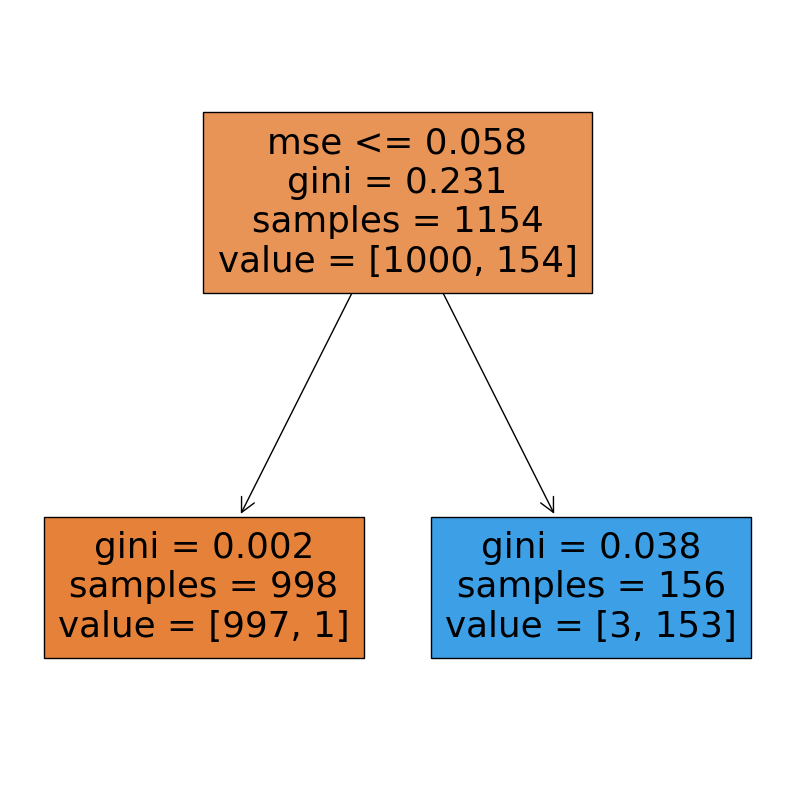

In [71]:
fig = plt.figure(figsize=(10, 10))
_ = tree.plot_tree(model_tree, feature_names=['mse'], filled=True)

In [72]:
threshold = 0.058 / 100
threshold

0.00058

Поиск порога через ROC-кривую

In [73]:
preds = model_1.predict(test_data)

119/119 [==============================] - 1s 10ms/step


In [89]:
from sklearn.metrics import roc_curve, auc

def find_optimal_cutoff(test_labels, test_scores):
    fpr, tpr, thresholds = roc_curve(test_labels, test_scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

mse_list = []

for i in range(len(test_data)):
    mse_list.append(np.mean(np.square(test_data[i]-preds[i])))

optimal_threshold = find_optimal_cutoff(df_test['class'], mse_list)
print(optimal_threshold)

0.0007636979


## Финальный расчет

In [90]:
def get_preds(imgs, preds, threshold=0.1):
    labels = []
    for i in range(len(preds)):
        mse = np.mean(np.square(imgs[i]-preds[i]))
        if mse < threshold:
            labels.append(0)
        else: 
            labels.append(1)
    return np.asarray(labels)

In [91]:
tn, fp, fn, tp = confusion_matrix(df_test['class'], get_preds(test_data, preds, threshold=optimal_threshold)).ravel()
print("TPR = {}, TNR = {}, threshold = {}".format(tp/(tp+fn), tn/(tn+fp), optimal_threshold))

TPR = 0.7906976744186046, TNR = 0.9852660300136425, threshold = 0.0007636978989467025


In [92]:
tn, fp, fn, tp = confusion_matrix(df_test['class'], get_preds(test_data, preds, threshold=threshold)).ravel()
print("TPR = {}, TNR = {}, threshold = {}".format(tp/(tp+fn), tn/(tn+fp), threshold))

TPR = 0.9122807017543859, TNR = 0.9238744884038199, threshold = 0.00058


In [93]:
model_1.save("Models/hw_2.keras")

Один из способов поиска порога сумел дать необходимый результат  
`TPR` = 0.912   
`TNR` = 0.924